In [1]:
import json
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

## Load Data

In [2]:
csv_path  = './youtube/GBvideos.csv'
json_path = './youtube/US_category_id.json'

df = pl.read_csv(csv_path)

with open(json_path, 'r') as f:
    categories = json.load(f)
    
id_to_category = {}
for c in categories['items']:
    id_to_category[int(c['id'])] = c['snippet']['title']

## Pre-processing

### Cleaning

In [3]:
date_column_format = {
    "trending_date": '%y.%d.%m',
    "publish_time": '%Y-%m-%dT%H:%M:%S%.fZ'
}

In [4]:
def parse_dates(df: pl.DataFrame, date_cols: Dict[str, str]) -> pl.DataFrame:
    expressions = []
    for date_col, format in date_cols.items():
        expressions.append(pl.col(date_col).str.to_date(format=format))

    df = df.with_columns(expressions)
    return df

In [5]:
df = parse_dates(df, date_column_format).with_columns(
    pl.col("category_id").map_dict(id_to_category)
)

### Feature Engineering

#### Rations and Derived Features

In [6]:
df = df.with_columns(
    time_to_trending=pl.col("trending_date") - pl.col("publish_time").dt.date(),
    likes_to_dislike_ratio=pl.col("likes") / pl.col("dislikes"),
    likes_to_views_ratio=pl.col("likes") / pl.col("views"),
    comments_to_views_ratio=pl.col("comment_count") / pl.col("views"),
)
print(df[["trending_date", "publish_time", "time_to_trending"]].sample(2))

print(df[["likes", "dislikes", "likes_to_dislike_ratio"]].sample(2))

shape: (2, 3)
┌───────────────┬──────────────┬──────────────────┐
│ trending_date ┆ publish_time ┆ time_to_trending │
│ ---           ┆ ---          ┆ ---              │
│ date          ┆ date         ┆ duration[ms]     │
╞═══════════════╪══════════════╪══════════════════╡
│ 2018-04-07    ┆ 2018-04-04   ┆ 3d               │
│ 2018-01-25    ┆ 2018-01-16   ┆ 9d               │
└───────────────┴──────────────┴──────────────────┘
shape: (2, 3)
┌───────┬──────────┬────────────────────────┐
│ likes ┆ dislikes ┆ likes_to_dislike_ratio │
│ ---   ┆ ---      ┆ ---                    │
│ i64   ┆ i64      ┆ f64                    │
╞═══════╪══════════╪════════════════════════╡
│ 13498 ┆ 494      ┆ 27.323887              │
│ 1389  ┆ 26       ┆ 53.423077              │
└───────┴──────────┴────────────────────────┘


#### Month, Year and Weekdays

In [7]:
df = df.with_columns(
    trending_weekday = pl.col('trending_date').dt.weekday(),
    trending_month = pl.col('trending_date').dt.month(),
    trending_year = pl.col("trending_date").dt.year()
)

#### Split Tags

In [8]:
df = df.with_columns(pl.col('tags').str.split('|'))

## Analysis

### Time to get to Trending

#### What's the median time to get to trending tab?

In [9]:
time_to_trending_df = df.groupby(
    ["video_id", "title", "category_id", "channel_title"]
).agg(
    pl.col("time_to_trending").min().dt.days(),
    pl.col("trending_date").min().dt.date().alias("first_day_in_trending"),
    pl.col("trending_date").max().dt.date().alias("last_day_in_trending"),
    (pl.col("trending_date").max() - pl.col("trending_date").min())
    .dt.days()
    .alias("days_in_trending"),
)
print(time_to_trending_df.sample(3))
print(
    f"Average time to trending is {time_to_trending_df['time_to_trending'].mean()} days"
)
print(
    f"Median time to trending is {time_to_trending_df['time_to_trending'].median()} days"
)

shape: (3, 8)
┌──────────┬──────────┬───────────┬────────────┬────────────┬────────────┬────────────┬────────────┐
│ video_id ┆ title    ┆ category_ ┆ channel_ti ┆ time_to_tr ┆ first_day_ ┆ last_day_i ┆ days_in_tr │
│ ---      ┆ ---      ┆ id        ┆ tle        ┆ ending     ┆ in_trendin ┆ n_trending ┆ ending     │
│ str      ┆ str      ┆ ---       ┆ ---        ┆ ---        ┆ g          ┆ ---        ┆ ---        │
│          ┆          ┆ str       ┆ str        ┆ i64        ┆ ---        ┆ date       ┆ i64        │
│          ┆          ┆           ┆            ┆            ┆ date       ┆            ┆            │
╞══════════╪══════════╪═══════════╪════════════╪════════════╪════════════╪════════════╪════════════╡
│ jxFwvwYP ┆ SOULCALI ┆ Gaming    ┆ BANDAI     ┆ 1          ┆ 2018-01-26 ┆ 2018-02-01 ┆ 6          │
│ Pcs      ┆ BUR VI - ┆           ┆ NAMCO Ente ┆            ┆            ┆            ┆            │
│          ┆ PS4/XB1/ ┆           ┆ rtainment  ┆            ┆            ┆   

In [10]:
time_to_trending_df = time_to_trending_df.filter(pl.col("time_to_trending") <= 60)
print(f"Average time to trending is {time_to_trending_df['time_to_trending'].mean()} days")
print(f"Median time to trending is {time_to_trending_df['time_to_trending'].median()} days")

Average time to trending is 3.7224563515954245 days
Median time to trending is 2.0 days


#### What categories consistently achieve the fastst trending status?

In [11]:
def avg_frequent(
    df: pl.DataFrame,
    by: str,
    frequency_threshold: int,
    metric: str = "time_to_trending",
) -> pl.DataFrame:

    results = (
        df.with_columns(times_in_trending=pl.count().over(by))
        .filter(pl.col("times_in_trending") >= frequency_threshold)
        .groupby(by)
        .agg(pl.col(metric).mean())
        .sort(metric)
    )

    return results

In [12]:
fastest_category_to_trending = avg_frequent(
    time_to_trending_df, by="category_id", frequency_threshold=100
).head(3)
fastest_channel_to_trending = avg_frequent(
    time_to_trending_df, by="channel_title", frequency_threshold=10
).head(3)

print(fastest_category_to_trending)
print(fastest_channel_to_trending)

shape: (3, 2)
┌───────────────┬──────────────────┐
│ category_id   ┆ time_to_trending │
│ ---           ┆ ---              │
│ str           ┆ f64              │
╞═══════════════╪══════════════════╡
│ Comedy        ┆ 2.955882         │
│ Howto & Style ┆ 3.146465         │
│ Sports        ┆ 3.290323         │
└───────────────┴──────────────────┘
shape: (3, 2)
┌───────────────────────────────────┬──────────────────┐
│ channel_title                     ┆ time_to_trending │
│ ---                               ┆ ---              │
│ str                               ┆ f64              │
╞═══════════════════════════════════╪══════════════════╡
│ The Tonight Show Starring Jimmy … ┆ 1.196078         │
│ Saturday Night Live               ┆ 1.342105         │
│ TheEllenShow                      ┆ 1.361702         │
└───────────────────────────────────┴──────────────────┘


### Time in Trending

#### Which categories stay in trending the longest?

In [13]:
longest_trending_categories = avg_frequent(
    time_to_trending_df,
    by="category_id",
    frequency_threshold=100,
    metric="days_in_trending",
).tail(3)

print(longest_trending_categories)

shape: (3, 2)
┌──────────────────┬──────────────────┐
│ category_id      ┆ days_in_trending │
│ ---              ┆ ---              │
│ str              ┆ f64              │
╞══════════════════╪══════════════════╡
│ Entertainment    ┆ 9.956571         │
│ Film & Animation ┆ 12.470297        │
│ Music            ┆ 15.165924        │
└──────────────────┴──────────────────┘


#### Which channel consistently stays in trending the longest?

In [14]:
longest_trending_channels = avg_frequent(
    time_to_trending_df,
    by="channel_title",
    frequency_threshold=10,
    metric="days_in_trending",
).tail(3)

print(longest_trending_channels)

shape: (3, 2)
┌──────────────────┬──────────────────┐
│ channel_title    ┆ days_in_trending │
│ ---              ┆ ---              │
│ str              ┆ f64              │
╞══════════════════╪══════════════════╡
│ WIRED            ┆ 13.2             │
│ HBO              ┆ 14.1             │
│ jypentertainment ┆ 14.5             │
└──────────────────┴──────────────────┘


### Trending over Time

#### Monthly Category Counts

In [15]:
top_categories = (
    df["category_id"].value_counts(sort=True).head(7)["category_id"].to_list()
)
top_categories

['Music',
 'Entertainment',
 'People & Blogs',
 'Film & Animation',
 'Howto & Style',
 'Sports',
 'Comedy']

In [16]:
trending_monthly_stats = df.groupby_dynamic(
    index_column="trending_date",
    every="1mo",
    closed="both",
    by="category_id",
    include_boundaries=True,
).agg(
    pl.col("video_id").n_unique().alias("videos_number"),
)

print(trending_monthly_stats.sample(3))

shape: (3, 5)
┌──────────────────────┬─────────────────────┬─────────────────────┬───────────────┬───────────────┐
│ category_id          ┆ _lower_boundary     ┆ _upper_boundary     ┆ trending_date ┆ videos_number │
│ ---                  ┆ ---                 ┆ ---                 ┆ ---           ┆ ---           │
│ str                  ┆ datetime[ms]        ┆ datetime[ms]        ┆ date          ┆ u32           │
╞══════════════════════╪═════════════════════╪═════════════════════╪═══════════════╪═══════════════╡
│ Travel & Events      ┆ 2018-01-01 00:00:00 ┆ 2018-02-01 00:00:00 ┆ 2018-01-01    ┆ 4             │
│ Science & Technology ┆ 2017-12-01 00:00:00 ┆ 2018-01-01 00:00:00 ┆ 2017-12-01    ┆ 12            │
│ Science & Technology ┆ 2018-06-01 00:00:00 ┆ 2018-07-01 00:00:00 ┆ 2018-06-01    ┆ 1             │
└──────────────────────┴─────────────────────┴─────────────────────┴───────────────┴───────────────┘


Text(0.5, 1.0, 'Total Number of Videos in Trending per Category per Month')

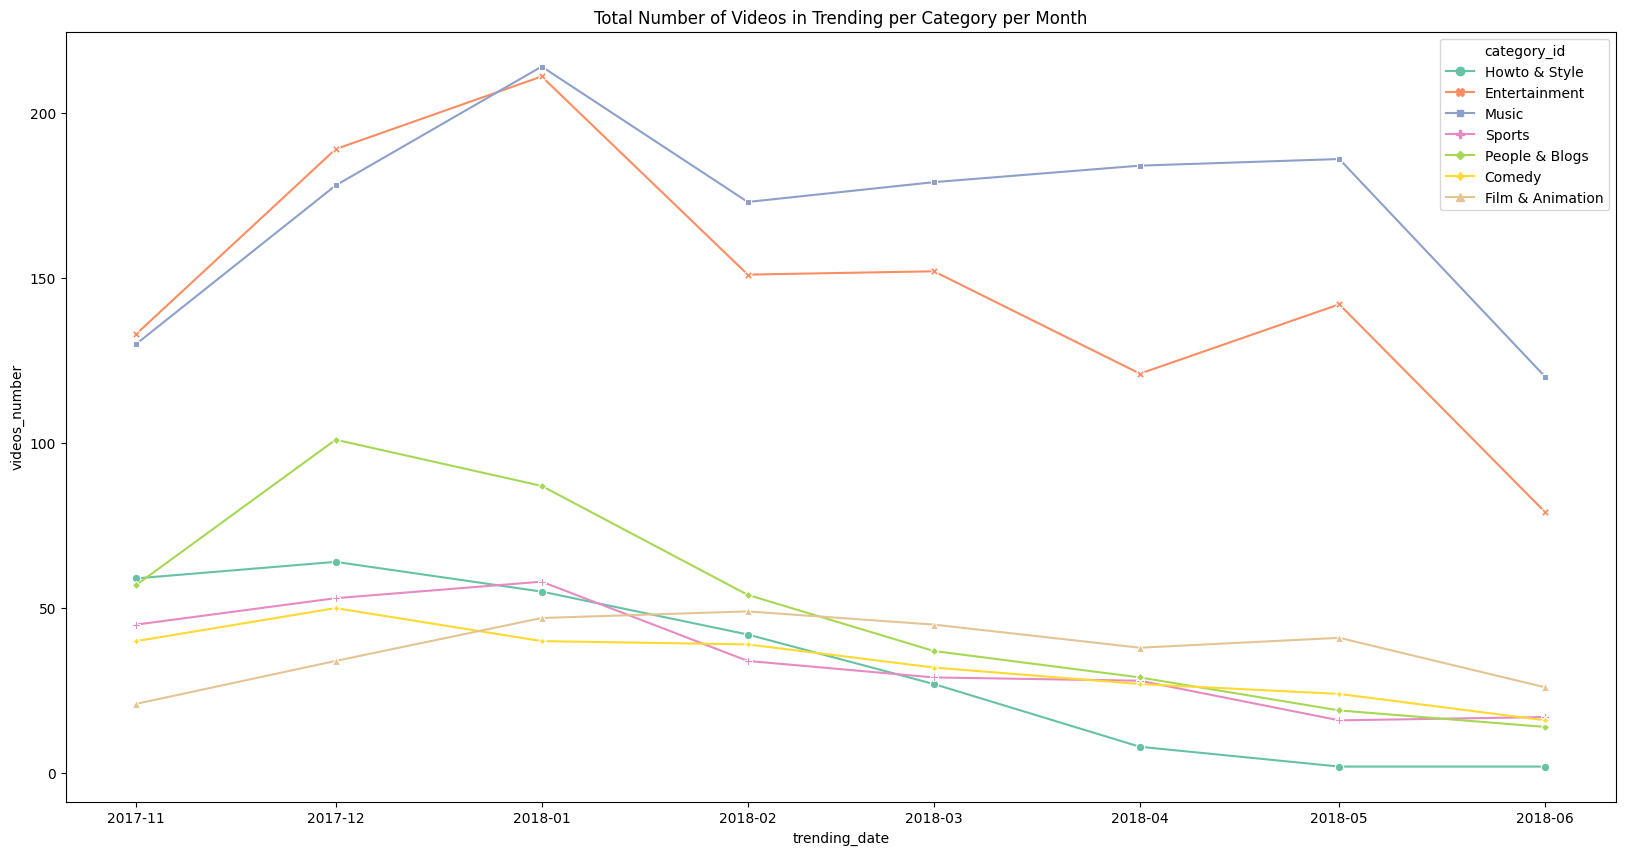

In [17]:
plotting_df = trending_monthly_stats.filter(pl.col("category_id").is_in(top_categories))

sns.lineplot(
    x=plotting_df["trending_date"],
    y=plotting_df["videos_number"],
    hue=plotting_df["category_id"],
    style=plotting_df["category_id"],
    markers=True,
    dashes=False,
    palette='Set2'
)

plt.title("Total Number of Videos in Trending per Category per Month")

Text(0.5, 1.0, ' Number of New Trending Videos per Category per Month')

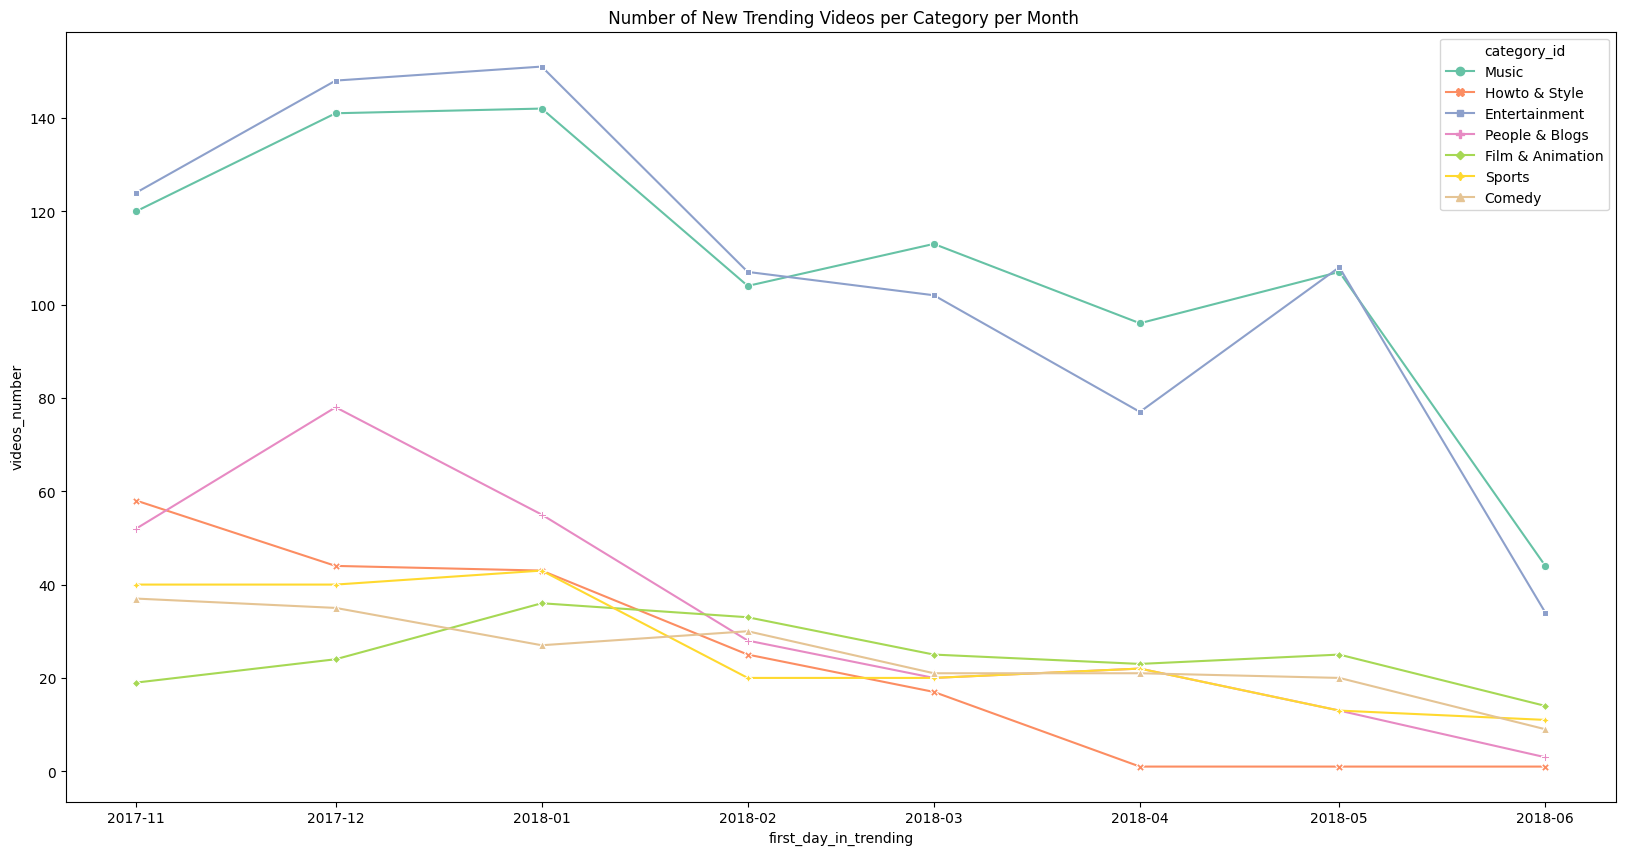

In [18]:
trending_monthly_stats_unique = (
    time_to_trending_df.sort("first_day_in_trending")
    .groupby_dynamic(
        index_column="first_day_in_trending",
        every="1mo",
        by="category_id",
        include_boundaries=True,
    )
    .agg(pl.col("video_id").n_unique().alias("videos_number"))
)

plotting_df = trending_monthly_stats_unique.filter(pl.col("category_id").is_in(top_categories))
sns.lineplot(
    x=plotting_df["first_day_in_trending"],
    y=plotting_df["videos_number"],
    hue=plotting_df["category_id"],
    style=plotting_df["category_id"],
    markers=True,
    dashes=False,
    palette='Set2'
)

plt.title(" Number of New Trending Videos per Category per Month")

### Running Average Views per Category

In [35]:
views_per_category_date = (
    df.groupby(["category_id", "trending_date"])
    .agg(pl.col("views").sum())
    .sort(["category_id", "trending_date"])
)
views_per_category_date.sample(3)

category_id,trending_date,views
str,date,i64
"""Comedy""",2018-02-02,15024034
"""Science & Tech…",2018-01-14,3090670
"""Entertainment""",2017-12-10,256764066


In [36]:
views_per_category_date_rolling = views_per_category_date.groupby_rolling(
    index_column="trending_date", 
    by="category_id", 
    period="1w"
).agg(
    pl.col("views").mean().alias("rolling_weekly_average")
)
views_per_category_date_rolling.sample(3)

category_id,trending_date,rolling_weekly_average
str,date,f64
"""Music""",2018-03-10,1.2122e9
"""People & Blogs…",2018-02-19,8.0221e7
"""Film & Animati…",2018-01-12,1.0257147e7


Text(0.5, 1.0, '7-day Views Average')

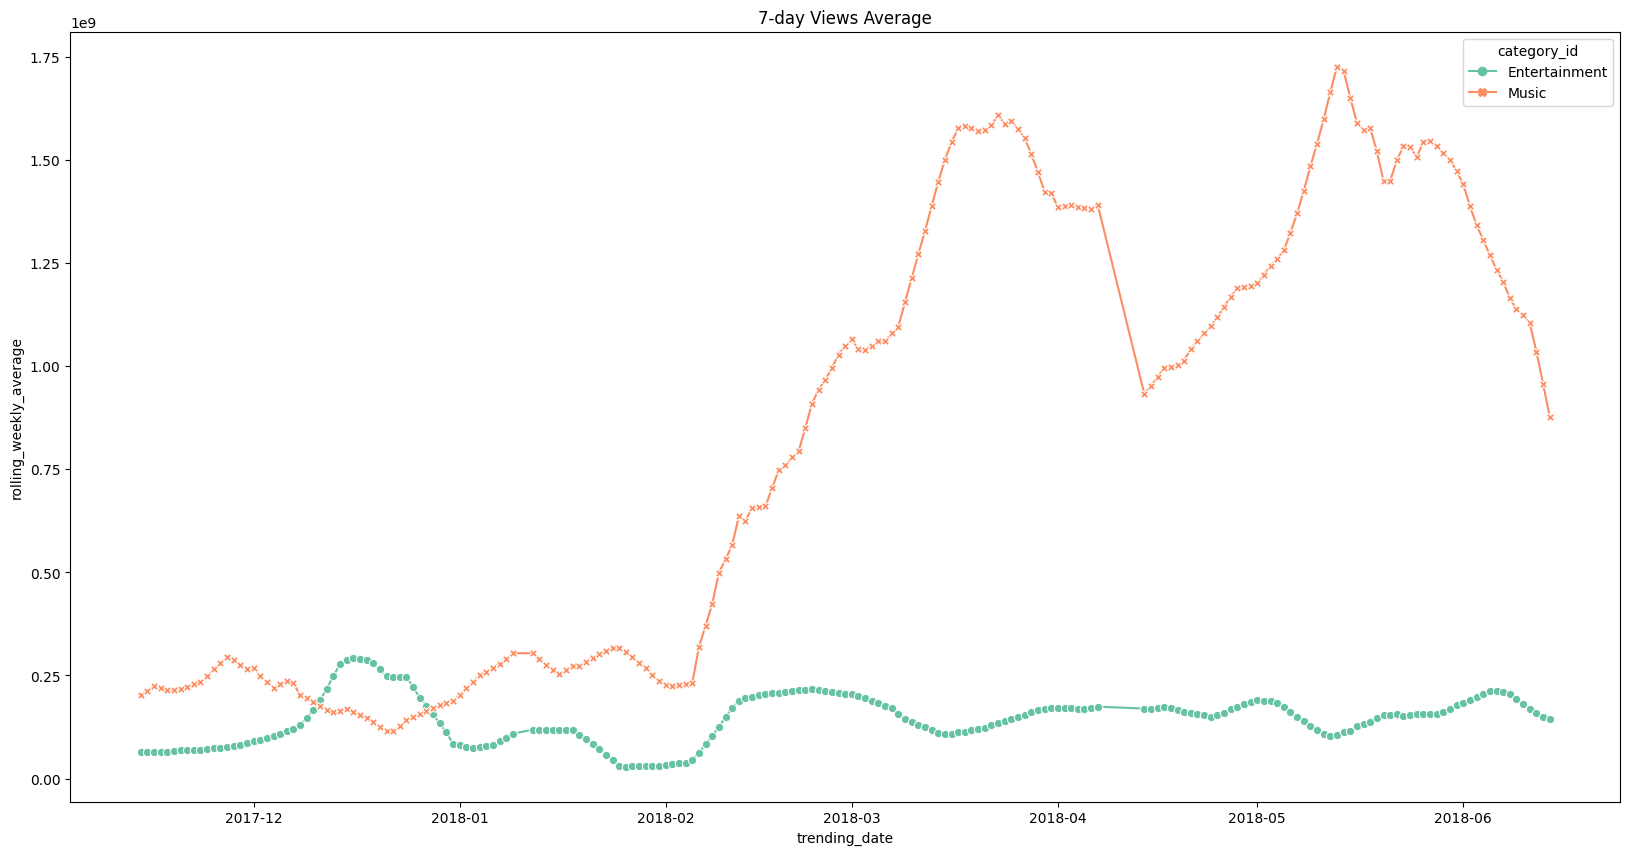

In [21]:
plotting_df = views_per_category_date_rolling.filter(pl.col("category_id").is_in(['Music', 'Entertainment']))
sns.lineplot(
    x=plotting_df["trending_date"],
    y=plotting_df["rolling_weekly_average"],
    hue=plotting_df["category_id"],
    style=plotting_df["category_id"],
    markers=True,
    dashes=False,
    palette='Set2'
)

plt.title("7-day Views Average")